In [1]:
import numpy as np
import pydicom as pyd
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 


In [2]:
data_path='./Lung-DICOM'
output_path='../Project'


In [3]:
# this function is fixing the missing values (if any) in the Slice Thickness Metadata
def load_scan(path):#We can also do it for the other code, do it later.
    # replace it with os.walk
    slices=[pyd.dcmread(path+'/'+s) for s in os.listdir(path)]#List comprehension
    #Sort the list by Instance number, instance is a unique key in each of the DICOM file
    slices.sort(key=lambda x: int(x.InstanceNumber)) 
    try:#Slice thickness is along z axis, but we dont know actual coordinates because of reference issues, so 
        #we define slice_thickness as difference.
        silce_thickness=np.abs(slices[0].ImagePositionPatient[2]-slices[1].ImagePositionPatient[2])
    except:
        slice_thickness=np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

        
        # Slice location and image position [2] are same, this error handler ensures that if there is a missing value in image position, it takes slice location    for s in slices:#For every slice it will set the attribute to the value of above array
        s.SliceThickness=slice_thickness
    return slices

    
def get_pixels_hu(scans):
    image=np.stack(list(ds.pixel_array for ds in scans))#We have stacked all the arrays(pixel arrays) as one. 
    image=image.astype(np.int16)#Image is the' combined effect' of slices' pixels data
    intercept=scans[0].RescaleIntercept# These two attributes are already present in ds(ResInter and Slope)
    slope=scans[0].RescaleSlope
    image[image == -2000] = 0 #
    if slope !=1:#slope is assumed to be one generally
        image = slope * image.astype(np.float64)
        image=image.astype(np.int16)
    image=image+np.int16(intercept) #Formula for hu conversion: slope*image+intercept
    return np.array(image, dtype=np.int16)
id=0    


In [4]:
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)# for the second function patient is scans
# It should be noted that imgs contain pixel data and array used.


In [5]:
# print(patient)

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [ ]:
normalize(imgs)

In [6]:
# print(imgs)
#This has loaded all the arrays within the pixel array

In [7]:
output_path='../Project/GIT/data-analysis-diwali'

In [8]:
np.save(os.path.join(output_path,'/PROJECTIMGS_%d.npy'%(id)),imgs)

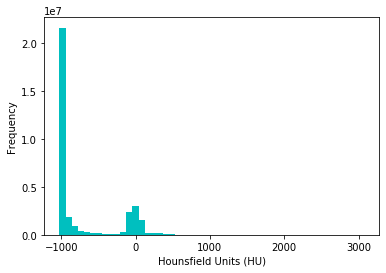

In [9]:
#Let's see graphically the statistics of bones and fires :p :
files_saved=(np.load(os.path.join(output_path,'/PROJECTIMGS_%d.npy'%(id))))
imgs_plot=files_saved.astype(np.float64)
plt.hist(imgs_plot.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [10]:
print(patient[0].PixelSpacing[0])


0.9765625


In [11]:
# printing out some parameters:
print('Pixel spacing(row,col):(%f,%f)'%(patient[0].PixelSpacing[0],patient[0].PixelSpacing[1]))
print('Slice Thickness: %f'%(patient[0].SliceThickness))
# we have rows=512, columns=512 so each represent approx 496 mm of length.
# each slice represents approximately 496 mm of data in length and width.
# if we scanned an 85-pound patient at the same “zoom” as a 190-pound patient, you wouldn’t want the scan 
# to occupy only the middle 250 voxels with a wide rim of air – you’d want to zoom in at the time of
# acquisition so that it makes a full use of the 512 x 512. This means that each CT scan actually 
# represents different dimensions in real life even though they are all 512 x 512 x Z slices.
print(patient[0].SliceThickness)
print((patient[0].PixelSpacing))

Pixel spacing(row,col):(0.976562,0.976562)
Slice Thickness: 3.000000
3
['0.9765625', '0.9765625']


In [12]:
# An isometric transformation is one where the distance between any two pixels in A, and the distance between the 
# equivalent two pixels in B does not change after the transformation has been applied
# There is always zoom/slice thickness invariance. A slice might have [2.4,3,3] as pixel spacing coordinates for one
# scan and for other it might be different. So we need to resample data by setting Pixel Spacing as [1,1,1]
id = 0

def resample(imgs_rsmpl,scan,set_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    spacing = list(map(float,list([scan[0].SliceThickness])+list(scan[0].PixelSpacing)))#We are adding two
#   lists here. The final concatenated list contain spacing as this order: z,x,y,(,slices,rows,col)
    print(spacing) 
    spacing = np.array(spacing)#To make an array 
    print(imgs_rsmpl.shape)
    resize_factor = spacing / set_spacing   #
    new_real_shape = imgs_rsmpl.shape * resize_factor    
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / imgs_rsmpl.shape
    set_spacing = spacing / real_resize_factor
    print(set_spacing)
    
    imgs_rsmpl = scipy.ndimage.interpolation.zoom(imgs_rsmpl, real_resize_factor)
    
    return imgs_rsmpl, set_spacing

print ("Shape beforeresampling\t", files_saved.shape)
imgs_after_resamp, spacing = resample(files_saved, patient, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)
# Various print commands are executed above to make sure what we are doing is right.:p

Shape beforeresampling	 (128, 512, 512)
[3.0, 0.9765625, 0.9765625]
(128, 512, 512)
[1. 1. 1.]
Shape after resampling	 (384, 500, 500)


In [ ]:
# https://en.wikipedia.org/wiki/Marching_cubes
# Using Polygon Meshes https://en.wikipedia.org/wiki/Polygon_mesh
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces       

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.get_fc((0.7, 0.7, 0.7))
    plt.show()



In [ ]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v, f)

In [ ]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [ ]:
img = imgs_after_resamp[260]
make_lungmask(img, display=True)

In [ ]:
masked_lung = []
for img in imgs_after_resamp:
    masked_lung.append(make_lungmask(img))